In [205]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm
from scipy.interpolate import interp1d

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [4]:
import faiss
from latent_rnn import create_LatentODE_model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [8]:
loader = torch.load('vae_train_loader.pt')

In [9]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.append(true)
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
    mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    ts.append(t)
    z_u, z_std = model.encoder_z0.forward(x, t)
    rec = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t)
    recs.append(rec)
    z_us.append(z_u)
    z_stds.append(z_std)
z_us = torch.cat(z_us,1).squeeze()
z_stds = torch.cat(z_stds,1).squeeze()
truths = torch.cat(truths,0).squeeze()

100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


### Build db

In [11]:
z_us = z_us.detach().cpu().numpy()

In [48]:
norms=np.linalg.norm(z_us, axis=1)

In [56]:
db_vecs=z_us/norms.reshape(-1,1)

In [58]:
db_vecs.shape

(450, 30)

In [64]:
d = db_vecs.shape[1]; d

30

In [65]:
db = faiss.IndexFlatIP(d)

In [66]:
db.add(db_vecs)

In [67]:
db.ntotal

450

### Query

Query within: 

In [125]:
ix = 30

In [126]:
y=truths[ix].squeeze().detach().cpu().numpy()

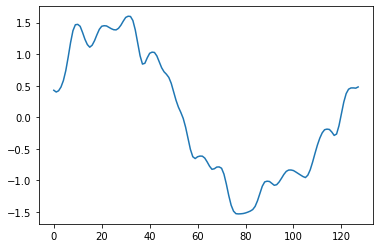

In [128]:
v = z_us[ix].reshape(1,-1)

In [129]:
v = v/np.linalg.norm(v)

In [162]:
probs, ixs = db.search(v, k=4)
ixs = ixs[0]
probs = probs[0]

In [155]:
ixs

array([ 30, 444, 255, 297])

In [132]:
truths[ix].squeeze().detach().cpu().numpy().shape

(128,)

In [156]:
y_q = []
for i in list(ixs):
    print(i)
    y = truths[i].squeeze().detach().cpu().numpy()
    y_q.append(y)
#     plt.figure()
#     sns.lineplot(x=np.arange(len(y)), y=y)
#     plt.show()

30
444
255
297


In [157]:
v

array([[-0.09643395,  0.02988408, -0.18040645,  0.21420844,  0.09963075,
        -0.29191032, -0.22903219, -0.06334547, -0.01100141,  0.25744852,
        -0.3888896 ,  0.2670434 ,  0.0143118 , -0.2307476 ,  0.01639056,
         0.14631182,  0.04759657, -0.17314442, -0.21704362, -0.09590986,
         0.10907108,  0.04991456,  0.15559371,  0.3020873 , -0.10146172,
         0.19113864,  0.25887492,  0.21164869, -0.11850807,  0.06787532]],
      dtype=float32)

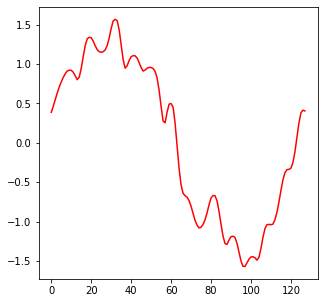

In [174]:
plt.figure(figsize=(5,5))
sns.lineplot(x=np.arange(len(y)), y=y, color='r')

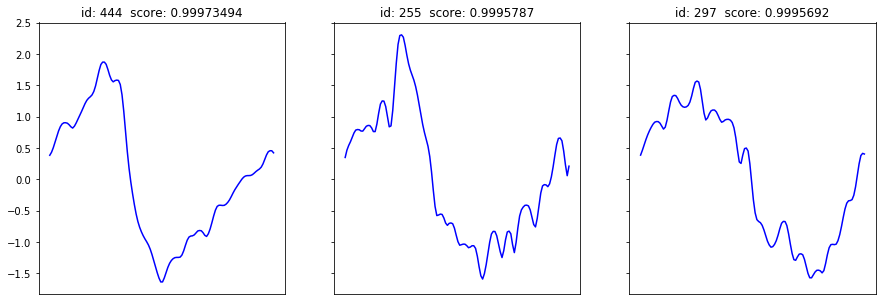

In [170]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i in range(len(y_q)):
    if i == 0:
        continue
    ax = axes[i-1]
    ax.set_xticks(ticks=[])
    ax.set_title('id: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
    sns.lineplot(x=np.arange(len(y_q[i])), y=y_q[i], color='b', ax=ax)

### Batch query (most bizarre)

Pairwise similarity for objects within the database. If we query the most common for each, we can sort by what time object with the lowest probability is. This will give us the most unique objects.

In [118]:
probs, ixs = db.search(db_vecs, k=1)

In [119]:
len(probs)

450

In [120]:
probs.min()

0.99999976

### Strange queries / unnatural source search

In [193]:
np.pi

3.141592653589793

In [194]:
s="{0:b}".format(314159); s

'1001100101100101111'

In [195]:
s = list(str(s))

In [203]:
s = np.array(s).astype(np.float32)

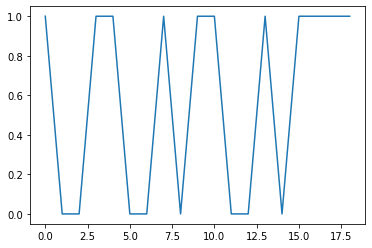

In [204]:
sns.lineplot(x=np.arange(len(s)), y=s)

In [206]:
interp1d(x=np.arange(100), y=s)

ValueError: x and y arrays must be equal in length along interpolation axis.